['(8,1)', '(7,1)', '(6,1)', '(4,2)', '(5,2)', '(6,2)', '(7,2)', '(8,2)', '(9,2)', '(10,2)', '(11,3)', '(10,3)', '(9,3)', '(8,3)', '(7,3)', '(6,3)', '(5,3)', '(4,3)', '(3,3)', '(2,4)', '(3,4)', '(4,4)', '(5,4)', '(6,4)', '(7,4)', '(8,4)', '(9,4)', '(10,4)', '(11,4)', '(12,5)', '(11,5)', '(10,5)', '(9,5)', '(8,5)', '(7,5)', '(6,5)', '(5,5)', '(4,5)', '(3,5)', '(2,5)', '(2,6)', '(3,6)', '(4,6)', '(5,6)', '(6,6)', '(7,6)', '(8,6)', '(9,6)', '(10,6)', '(11,6)', '(12,6)', '(12,7)', '(11,7)', '(10,7)', '(9,7)', '(8,7)', '(7,7)', '(6,7)', '(5,7)', '(4,7)', '(3,7)', '(2,7)', '(1,7)', '(1,8)', '(2,8)', '(3,8)', '(4,8)', '(5,8)', '(6,8)', '(7,8)', '(8,8)', '(9,8)', '(10,8)', '(11,8)', '(12,8)', '(13,8)', '(12,9)', '(11,9)', '(10,9)', '(9,9)', '(8,9)', '(7,9)', '(6,9)', '(5,9)', '(4,9)', '(3,9)', '(2,9)', '(1,9)', '(2,10)', '(3,10)', '(4,10)', '(5,10)', '(6,10)', '(7,10)', '(8,10)', '(9,10)', '(10,10)', '(11,10)', '(12,10)', '(12,11)', '(11,11)', '(10,11)', '(9,11)', '(8,11)', '(7,11)', '(6,11)', 

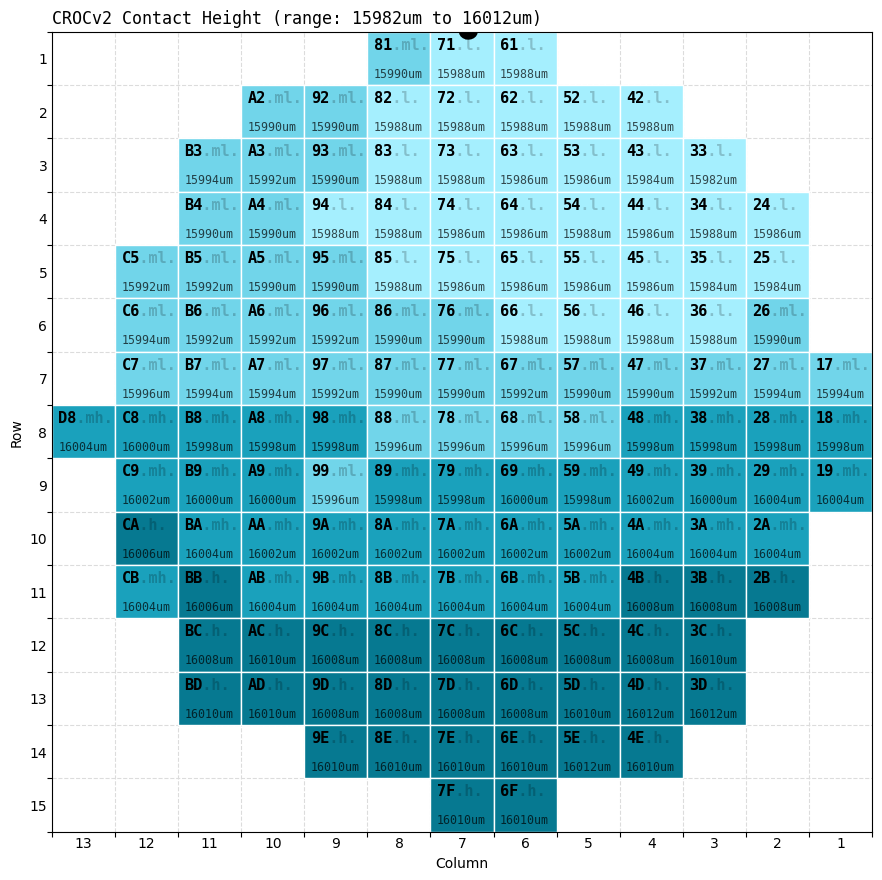

In [1]:
#Topography map
import os
import glob
import numpy as np
from scipy import stats
import re
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
from wlt.duts.wafers import WAFER_MAPS
from wlt.wafermap import WaferMap

#Open file (change filepath as necessary, glob allows for wildcard usage but it isn't required)
with open(glob.glob(os.path.expanduser('~/Desktop/log_files/2nd*/*06H2*.log'))[0], 'r') as file:
    log_content = file.readlines()

#Set up patterns
waferpattern = r'Wafer: (\w\w\w\w)'
waferid = ""
chippattern = r'(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}) \| WaferTester \((\S\S\S\S)\)   \| INFO     \| Testing chip \S\S\S\S\S\S\S\S\S\S\S\S(\S\S)'
contactpattern = r'(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}) \| WaferTester \((\S\S\S\S)\)   \| INFO     \| Found contact height: (.*)'
chipids = []
contactheight = []
for line in log_content:
    chipmatch = re.search(chippattern, line)
    contactmatch = re.search(contactpattern, line)
    wafermatch = re.search(waferpattern, line)
    if chipmatch:
        chipid = str(chipmatch.group(3))
        chipids.append(chipid)
    elif contactmatch:
        contactheight.append(contactmatch.group(3))
    elif wafermatch:
        waferid = str(wafermatch.group(1))
                             
#Organize data
contactheight = [int(i[:5]) for i in contactheight]

#Format chips (e.g. A9 is (10,9))
chip_coords = [f'({s[0]},{s[1]})' for s in chipids]
letter_to_number = {
    'A': '10', 'B': '11', 'C': '12', 'D': '13', 'E': '14', 'F': '15'}
def multiple_substitutions(s):
    pattern = re.compile('|'.join(map(re.escape, letter_to_number.keys())))
    return pattern.sub(lambda match: letter_to_number[match.group(0)], s)
chiplocations = [multiple_substitutions(s) for s in chip_coords]

print(chiplocations)

#determine status ranges
min_height = min(contactheight)
max_height = max(contactheight)
height_range = max_height - min_height
bin_size = height_range / 4.0

#sort chips into statuses
low = []
medlow = []
medhigh = []
high = []
low_c = []
medlow_c = []
medhigh_c = []
high_c = []
for i in range(len(contactheight)):
    value_height = contactheight[i]
    value_chip = chiplocations[i]
    if value_height < min_height + bin_size:
        low.append(value_chip)
        low_c.append(value_height)
    elif value_height < min_height + 2 * bin_size:
        medlow.append(value_chip)
        medlow_c.append(value_height)
    elif value_height < min_height + 3 * bin_size:
        medhigh.append(value_chip)
        medhigh_c.append(value_height)
    else:
        high.append(value_chip)
        high_c.append(value_height)

#find out which chips are at the median, max, and min height
median = np.median(contactheight)
if median not in contactheight:
    greater_than_median = [num for num in contactheight if num > median]
    next_highest = min(greater_than_median)
    '''number of chips at next highest value above median'''
median_chips = []
next_chips = []
max_chips = []
min_chips = []
for i in range(len(contactheight)):
    if contactheight[i] == median:
        median_chips.append(chipids[i])
    if contactheight[i] == next_highest:
        next_chips.append(chipids[i])
    if contactheight[i] == max_height:
        max_chips.append(chipids[i])
    if contactheight[i] == min_height:
        min_chips.append(chipids[i])

#make dictionaries
low_dict = {k:v for k,v in zip(low,low_c)}
medlow_dict = {k:v for k,v in zip(medlow,medlow_c)}
medhigh_dict = {k:v for k,v in zip(medhigh,medhigh_c)}
high_dict = {k:v for k,v in zip(high,high_c)}

#set statuses
chip_statuses = {
		( 1, ''): low_dict,    
		( 2, ''): medlow_dict,                
		( 3, ''): medhigh_dict, 
		( 4, ''): high_dict,              
    }

WaferMap.STATUS_COLORS = {1: '#A5EFFE', 2: '#71d5ea', 3: '#1aa1bc', 4: '#067991'}
WaferMap.STATUS_NAMES =  {1: 'l',       2: 'ml',       3: 'mh',       4: 'h'}

#Create map
loop = 0
ch_type ='CROCv2'
wafer_map = WaferMap(chip_type=ch_type, title=f'{ch_type} Contact Height (range: {min_height}um to {max_height}um)')
for (chip_status, chip_value), x in chip_statuses.items():
    for chips,heights in x.items():
        subtext = f"{heights}um"
        wafer_map.set_chip(eval(chips), chip_status, subtext)
        loop = loop + 1

#printing stats
print(f'Range: {min_height}um to {max_height}um ({max_height-min_height}um)')
print(f'Bins:\n - Low (l):          {min_height}-{int(min_height+bin_size)}um\n - Medium low (ml):  {int(min_height+bin_size)}-{int(min_height+bin_size*2)}um\n - Medium high (mh): {int(min_height+bin_size*2)}-{int(min_height+bin_size*3)}um\n - High (h):         {int(min_height+bin_size*3)}-{int(max_height)}um')
print(f'Mean: {round(np.mean(contactheight),3)}um')
print(f'Median: {int(np.median(contactheight))}um')
print(f'Mode: {stats.mode(contactheight)[0]}um')
if median in contactheight:
    print(f'Chips at median height: {", ".join(median_chips)}')
elif median not in contactheight:
    print(f'Calculated median not in data set. Chips at next highest height ({next_highest}um): {next_chips}')
print(f'Chips at maximum height: {", ".join(max_chips)}')
print(f'Chips at minimum height: {", ".join(min_chips)}')

Range: -4um to 6um (10um)
Bins:
 - Low (l):          -4um or less
 - Medium low (ml):  2um
 - Medium (m):       0um
 - Medium high (mh): 2um
 - High (h):         4um or higher
Mean: 2.559um
Median: 2um
Mode: 2um
Chips at median height(2um): 81, 42, 52, 92, B3, 93, 73, 53, 33, 54, 74, 84, 94, A5, 95, 85, 55, 35, 26, 36, 66, 76, 86, 96, A6, B6, 87, 67, 27, 28, 78, 98, A8, C9, B9, 99, 89, 59, 8A, 9A, AA, BA, CB, BB, AB, 9B, 7B, 6B, 3C, 8C, 9C, AC, BD, AD, 4E, 8E, 6F
Chips at maximum asymmetry (6um): 24, 48, 58, 49, 4A, 5C, 5D, 4D, 5E, 7E, 9E, 7F
Chips at minimum asymmetry (-4um): 19


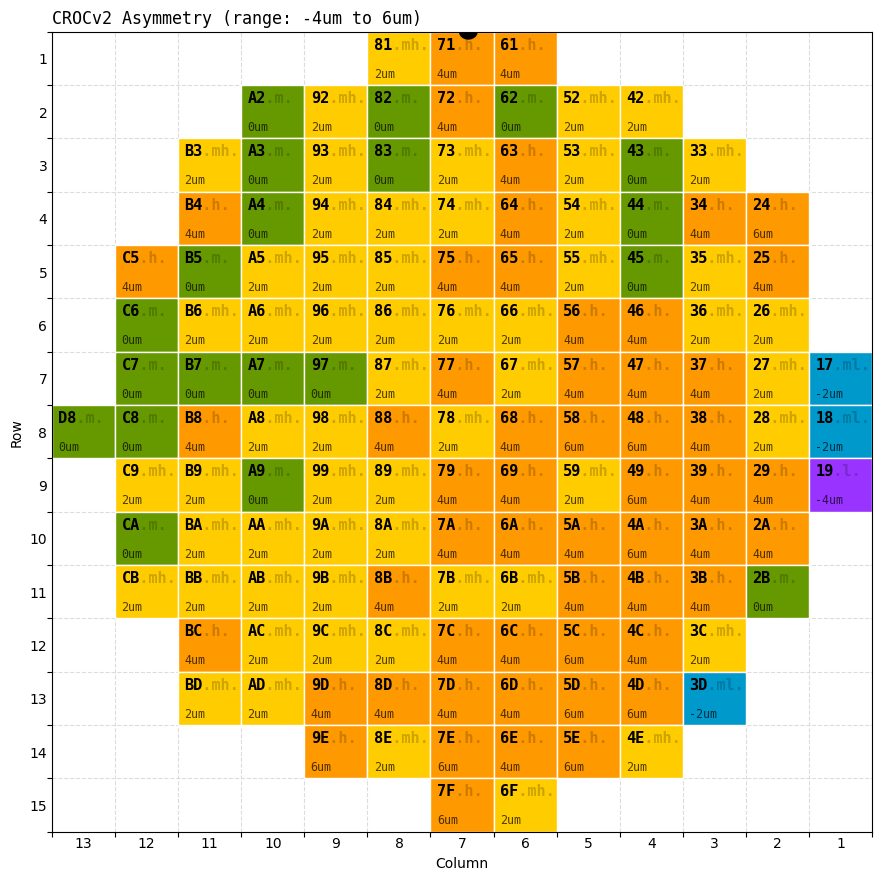

In [98]:
#Asymmetry map
import os
import glob
import numpy as np
from scipy import stats
import re
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
from wlt.duts.wafers import WAFER_MAPS
from wlt.wafermap import WaferMap

#Open file (change filepath as necessary, glob allows for wildcard usage but it isn't required)
with open(glob.glob(os.path.expanduser('~/Desktop/log_files/1st*/*07G5*.log'))[0], 'r') as file:
    log_content = file.readlines()

#Set up patterns
waferpattern = r'Wafer: (\w\w\w\w)'
waferid = ""
chippattern = r'(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}) \| WaferTester \((\S\S\S\S)\)   \| INFO     \| Testing chip \S\S\S\S\S\S\S\S\S\S\S\S(\S\S)'
contactpattern = r'(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}) \| WaferTester \((\S\S\S\S)\)   \| INFO     \| Found contact height: (.*)'
asympattern = r'.* \| .* \| .* \| Asymmetry \((.*) um\)'
edge1pattern = r'.* \| .* \| .* \| Edge sensor 1: (.*)'
edge2pattern = r'.* \| .* \| .* \| Edge sensor 2: (.*)'
chipids = []
contactheight = []
asymmetries = []
for i in range(len(log_content)):
    chipmatch = re.search(chippattern, log_content[i])
    contactmatch = re.search(contactpattern, log_content[i])
    wafermatch = re.search(waferpattern, log_content[i])
    if chipmatch:
        chipid = str(chipmatch.group(3))
        chipids.append(chipid)
    elif contactmatch:
        contactheight.append(contactmatch.group(3))
        asymmatch = re.search(asympattern, log_content[i-1])
        edge1match = re.search(edge1pattern, log_content[i-8])
        edge2match = re.search(edge2pattern, log_content[i-7])
        if asymmatch and edge1match and edge2match:
            edge1 = str(edge1match.group(1))
            edge2 = str(edge2match.group(1))
            if edge1 == "False" and edge2 == "True":
                asymmetries.append(asymmatch.group(1))
            elif edge1 == "True" and edge2 == "False":
                asymmetries.append(str('-' + asymmatch.group(1)))
            elif (edge1 == "True" and edge2 == "True") or (edge1 == "False" and edge2 == "False"):
                asymmetries.append(asymmatch.group(1))
            else:
                print('edge sensor error')
        else:
            print('no match')
    elif wafermatch:
        waferid = str(wafermatch.group(1))  
                
#Organize data
asymmetries = [int(i) for i in asymmetries]

#Format chips (e.g. A9 is (10,9))
chip_coords = [f'({s[0]},{s[1]})' for s in chipids]
letter_to_number = {
    'A': '10', 'B': '11', 'C': '12', 'D': '13', 'E': '14', 'F': '15'}
def multiple_substitutions(s):
    pattern = re.compile('|'.join(map(re.escape, letter_to_number.keys())))
    return pattern.sub(lambda match: letter_to_number[match.group(0)], s)
chiplocations = [multiple_substitutions(s) for s in chip_coords]

#determine status ranges
min_height = int(min(asymmetries))
max_height = int(max(asymmetries))
height_range = max_height - min_height
bin_size = height_range / 4.0

#sort chips into statuses
low = []
medlow = []
med = []
medhigh = []
high = []
other = []
low_c = []
medlow_c = []
med_c = []
medhigh_c = []
high_c = []
other_c = []
for i in range(len(asymmetries)):
    value_asym = asymmetries[i]
    value_chip = chiplocations[i]
    if int(value_asym) <= -4:
        low.append(value_chip)
        low_c.append(value_asym)
    elif int(value_asym) == -2:
        medlow.append(value_chip)
        medlow_c.append(value_asym)
    elif int(value_asym) == 0:
        med.append(value_chip)
        med_c.append(value_asym)
    elif int(value_asym) == 2:
        medhigh.append(value_chip)
        medhigh_c.append(value_asym)
    elif int(value_asym) >= 4:
        high.append(value_chip)
        high_c.append(value_asym)
    else: #just for errors
        other.append(value_chip)
        other_c.append(value_asym)

#find out which chips are at the median, max, and min height
median = np.median(asymmetries)
if median not in asymmetries:
    greater_than_median = [num for num in contactheight if num > median]
    next_highest = min(greater_than_median)
else: next_highest = None
median_chips = []
next_chips = []
max_chips = []
min_chips = []
for i in range(len(asymmetries)):
    if asymmetries[i] == median:
        median_chips.append(chipids[i])
    if asymmetries[i] == next_highest:
        next_chips.append(chipids[i])
    if asymmetries[i] == max_height:
        max_chips.append(chipids[i])
    if asymmetries[i] == min_height:
        min_chips.append(chipids[i])

#make dictionaries
low_dict = {k:v for k,v in zip(low,low_c)}
medlow_dict = {k:v for k,v in zip(medlow,medlow_c)}
med_dict = {k:v for k,v in zip(med,med_c)}
medhigh_dict = {k:v for k,v in zip(medhigh,medhigh_c)}
high_dict = {k:v for k,v in zip(high,high_c)}

#set statuses
chip_statuses = {
		( 1, ''): low_dict,    
		( 2, ''): medlow_dict,                
		( 3, ''): med_dict, 
		( 4, ''): medhigh_dict, 
		( 5, ''): high_dict,              
    }

WaferMap.STATUS_COLORS = {1: '#9933ff', 2: '#0099cc', 3: '#669900', 4: '#ffcc00', 5: '#ff9900'}
WaferMap.STATUS_NAMES =  {1: 'l',       2: 'ml',      3: 'm',       4: 'mh',      5: 'h'}  

#Create map
loop = 0
ch_type ='CROCv2'
wafer_map = WaferMap(chip_type=ch_type, title=f'{ch_type} Asymmetry (range: {min_height}um to {max_height}um)')
for (chip_status, chip_value), x in chip_statuses.items():
    for chips,heights in x.items():
        subtext = f"{heights}um"
        wafer_map.set_chip(eval(chips), chip_status, subtext)
        loop = loop + 1

#printing stats
print(f'Range: {min_height}um to {max_height}um ({max_height-min_height}um)')
print(f'Bins:\n - Low (l):          -4um or less\n - Medium low (ml):  2um\n - Medium (m):       0um\n - Medium high (mh): 2um\n - High (h):         4um or higher')
print(f'Mean: {round(np.mean(asymmetries),3)}um')
print(f'Median: {int(np.median(asymmetries))}um')
print(f'Mode: {stats.mode(asymmetries)[0]}um')
if median in asymmetries:
    print(f'Chips at median height({int(median)}um): {", ".join(median_chips)}')
elif median not in asymmetries:
    print(f'Calculated median not in data set. Chips at next highest height ({next_highest}um): {next_chips}')
print(f'Chips at maximum asymmetry ({max_height}um): {", ".join(max_chips)}')
print(f'Chips at minimum asymmetry ({min_height}um): {", ".join(min_chips)}')
